In [1]:
# Data processing libraries
import pandas as pd 
import numpy as  np

# Required imports for NLP and text analysis
import nltk 
from nltk.stem.snowball import EnglishStemmer 
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
from wordcloud import WordCloud
from PIL import Image
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
import spacy
import string
import regex as re

# Required library for misc visualization
import seaborn as sns

# Misc libraries
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Misc operation so that i can access my parent directory
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent)

# Importing my utility script
import util

# Importing textstat for Flesch Reading score
import textstat

# Required library for sentiment analysis - polarity score
from textblob import TextBlob

C:\Users\kwanv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# One time operation to download corpus

#nltk.download('words')

In [3]:
# Initializing NLP items

nlp = spacy.load("en_core_web_lg")
from nltk.corpus import stopwords as sw

stop_words = sw.words('english')
words = set(nltk.corpus.words.words())
punctuations = string.punctuation

In [4]:
sns.set(rc = {'figure.figsize':(15, 10)})

In [5]:
# Reading in data

data = pd.read_csv(parent + '\Recruitment.csv')

# Dropping irrelevant column
data = data.drop('in_balanced_dataset', axis = 1)

In [5]:
data.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f


In [6]:
# Every column has been stored as an object dtype. Furthermore, there are various null values interspersed throughout the dataset.
# The only non-null column is the title column.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

# Feature Engineering #1
### Creating City, State, and Country fields from location field

In [7]:
data[['Country', 'State', 'City']] = data['location'].str.split(',', expand = True).iloc[:, :3]

# Feature Engineering #2
### The industry field is long-tailed, and will pose a dimensionality challenge when modeling. 
### Therefore, a collapse procedure is being carried out here.

In [8]:
data['industry'].nunique()

131

### I need an algorithmic way of extracting common substrings. I decided to use the fuzzywuzzy library which calculates the Levenshtein distance between strings.

In [10]:
# Carrying out several tests to find similar strings

print(fuzz.partial_ratio('Education Management', 'Higher Education'))

print(process.extract('Management', data['industry'].tolist()))

print(process.extract('Investment', data['industry'].tolist()))

print(process.extract('Health', data['industry'].tolist()))

print(process.extract('Security', data['industry'].tolist()))

print(process.extract('Luxury', data['industry'].tolist()))

print(process.extract('Dining', data['industry'].tolist()))

print(process.extract('Food', data['industry'].tolist()))

56
[('Management Consulting', 90), ('Management Consulting', 90), ('Education Management', 90), ('Education Management', 90), ('Education Management', 90)]
[('Investment Management', 90), ('Investment Banking', 90), ('Investment Management', 90), ('Investment Management', 90), ('Investment Management', 90)]
[('Hospital & Health Care', 90), ('Hospital & Health Care', 90), ('Hospital & Health Care', 90), ('Hospital & Health Care', 90), ('Health, Wellness and Fitness', 90)]
[('Computer & Network Security', 90), ('Computer & Network Security', 90), ('Security and Investigations', 90), ('Computer & Network Security', 90), ('Security and Investigations', 90)]
[('Luxury Goods & Jewelry', 90), ('Luxury Goods & Jewelry', 90), ('Luxury Goods & Jewelry', 90), ('Luxury Goods & Jewelry', 90), ('Leisure, Travel & Tourism', 45)]
[('Writing and Editing', 75), ('Writing and Editing', 75), ('Mining & Metals', 75), ('Writing and Editing', 75), ('Professional Training & Coaching', 75)]
[('Food & Beverages

In [11]:
# Investigating similar industries through string matching

print(data['industry'][data['industry'].str.contains('Relations', na = False)].unique())

print(data['industry'][data['industry'].str.contains('and', na = False)].unique())

print(data['industry'][data['industry'].str.contains('Education', na = False)].unique())

print(data['industry'][data['industry'].str.contains('Management', na = False)].unique())

['Public Relations and Communications' 'Government Relations']
['Marketing and Advertising' 'Information Technology and Services'
 'Health, Wellness and Fitness' 'Staffing and Recruiting'
 'Public Relations and Communications' 'Logistics and Supply Chain'
 'Business Supplies and Equipment' 'Writing and Editing'
 'Security and Investigations' 'Motion Pictures and Film'
 'Packaging and Containers' 'Import and Export'
 'International Trade and Development' 'Translation and Localization'
 'Wine and Spirits' 'Museums and Institutions']
['Education Management' 'Primary/Secondary Education' 'Higher Education']
['Management Consulting' 'Education Management' 'Investment Management'
 'Nonprofit Organization Management']


In [10]:
# Turning off SettingWithCopyWarning which was created to warn of chained assignments
# This is irrelevant for our purposes, and adds no purpose other than to annoy

pd.options.mode.chained_assignment = None

### Collapsing together similar industries to reduce dimensionality
### Also grouping together industries with a count of 100 or less into a Miscellaneous category.

### The count of 100 was chosen as I want every industry which represents less than 1% of the total dataset to be bundled together.

In [13]:
# Collapsing together Health industries

data['industry'][data['industry'][data['industry'].str.contains('Health', na = False)].index] = 'Hospital & Healthcare'

# Collapsing together Banking & Financial industries

data['industry'][data['industry'][data['industry'].str.contains('Banking', na = False)].index] = 'Banking and Financial Services'
data['industry'][data['industry'][data['industry'].str.contains('Financial', na = False)].index] = 'Banking and Financial Services'

# Collapsing together 'Computer' industries

data['industry'][data['industry'][data['industry'].str.contains('Computer', na = False)].index] = 'Computer/IT/Software'

# Collapsing together IT & Information industries industries

data['industry'][data['industry'][data['industry'].str.contains('Information', na = False)].index] = 'Computer/IT/Software'
data['industry'][data['industry'][data['industry'].str.contains('Internet', na = False)].index] = 'Computer/IT/Software'

# Collapsing together Animation industry with Motion Pictures

data['industry'][data['industry'][data['industry'].str.contains('Animation', na = False)].index] = 'Motion Pictures & Film'

# Collapsing together Trade industry with EXIM

data['industry'][data['industry'][data['industry'].str.contains('Trade', na = False)].index] = 'Import and Export'

# Collapsing all management professions/industries into one Management category

data['industry'][data['industry'][data['industry'].str.contains('Management', na = False)].index] = 'Management'

# Collapsing all Education industries into one category

data['industry'][data['industry'][data['industry'].str.contains('Education', na = False)].index] = 'Education'

# Collapsing Plastic industry into Oil & Energy

data['industry'][data['industry'][data['industry'].str.contains('Plastic', na = False)].index] = 'Oil, Energy and Plastics'
data['industry'][data['industry'][data['industry'].str.contains('Oil', na = False)].index] = 'Oil, Energy and Plastics'

# Collapsing Staffing industry into Human Resources

data['industry'][data['industry'][data['industry'].str.contains('Staffing', na = False)].index] = 'Human Resources'

In [15]:
# Collapsing industries with count less than 100 into Miscellaneous category

for industry in data['industry'].value_counts()[data['industry'].value_counts() <= 100].index.tolist():
    data['industry'][data['industry'][data['industry'].str.contains(industry, na = False)].index] = 'Miscellaneous'

### The collapse operation led to a reduction of 111 categories.
### The final field contains only 20 unique values. 

In [16]:
data['industry'].nunique()

20

# Feature Engineering #3

### Creating a salary_mean field from salary_range

In [17]:
# Splitting the string by a delimiter

data['salary_range'] = data['salary_range'].str.split('-')

# Applying helper function to compute mean of min-max range

data['salary_mean'] = data['salary_range'].apply(util.salary_mean)

# Feature Engineering #4

### Text field clean-up.

### Creating lemmatized, and punctuation free versions of the text fields

In [19]:
# Adding HTML elements to stopwords

stop_words.extend(['etc', 'u', 'ul', 'br', 'b', 'i', 'false', 'li', 'w', 'ww', 'www', 'p', 'LsdException', 'nofollow', 'amp', 'grid', 'accent'])

clean_up_cols = ['company_profile', 'requirements', 'description', 'benefits']

for col in clean_up_cols:
    
    # name cleaned up column
    cleaned_col_name = col + '_cleaned'

    # initiate empty column
    data[cleaned_col_name] = ''


    for i in range(len(data[col])):

        # if data is na, place empty string
        if pd.isna(data[col][i]):
            data[cleaned_col_name][i] = np.NAN
        else:

            # dont need entire nlp pipeline so parser and ner are disabled        
            text_doc = nlp(data[col][i], disable=['parser', 'ner'])

            # text is lemmatized, converted to lowercase, and separated by whitespace
            text = [tok.lemma_.lower().strip() for tok in text_doc]

            # stopwords and punctuation marks are filtered out
            text = [tok for tok in text if tok in words and tok not in stop_words and tok not in punctuations and tok.isnumeric() is False]
            # the resulting token list is joined back into a sentence
            text =  ' '.join(text)

            data[cleaned_col_name][i] = text

# Feature Engineering #5

### Creating comma counters for each text field

In [20]:
data['commas_desc'] = data['description'].str.count(',')
data['commas_profile'] = data['company_profile'].str.count(',')
data['commas_requirement'] = data['requirements'].str.count(',')
data['commas_benefits'] = data['benefits'].str.count(',')

# Feature Engineering #5

### Creating whitespace counters for each text field

### Note: this field will be positively correlated with length of the text field for obvious reasons.
### In that case, this field might be redundant and lead to multi-collinearity

In [21]:
data['spaces_desc'] = data['description'].str.count(' ')
data['spaces_profile'] = data['company_profile'].str.count(' ')
data['spaces_requirement'] = data['requirements'].str.count(' ')
data['spaces_benefits'] = data['benefits'].str.count(' ')

# Feature Engineering #6

### Creating consecutive punctuation counters for each text field.

### Example - "this is, , an example sentence with consecutive punctuation marks!!"

### The example text contains 2 consecutive punctuation marks

In [22]:
clean_up_cols = ['company_profile', 'requirements', 'description', 'benefits']

for col in clean_up_cols:
    # name cleaned up column
    cleaned_col_name = col + '_consecpunc'

    # initiate empty column
    data[cleaned_col_name] = ''


    for i in range(len(data[col])):
        count = 0
        # if data is na, place empty string
        if pd.isna(data[col][i]):
            data[cleaned_col_name][i] = np.NAN
        else:

            # dont need entire nlp pipeline so parser and ner are disabled        
            text_doc = nlp(data[col][i], disable=['parser', 'ner'])

            tokens = [tok.lemma_.lower().strip() for tok in text_doc if tok.lemma_ != '-PRON-']
            tokens = list(zip(tokens[1:], tokens))
            for tok in tokens:
                if tok[0] in punctuations and tok[1] in punctuations:
                    count += 1

            data[cleaned_col_name][i] = count

# Feature Engineering #7

### Creating missing indicators for post attributes and text fields

In [23]:
# Creating missing indicators for post attributes

attributes = ['industry', 'function', 'requirements', 'benefits', 'description' ,'employment_type', 'salary_range', 'location']

for col in attributes:
    new_col =  'has_' + col
    data[new_col] = data[col].isna().astype(int)

# Feature Engineering 8

### Creating clickbait word counters

In [35]:
clickbait_words = ['earn', 'home', 'week', 'remote', 'daily', 'cash', 'high school', 'no degree']

In [78]:
clean_up_cols = ['company_profile_cleaned', 'requirements_cleaned', 'description_cleaned', 'benefits_cleaned']

for col in clean_up_cols:
    # name cleaned up column
    cleaned_col_name = col + '_clickbait_count'

    # initiate empty column
    data[cleaned_col_name] = ''
    

    for i in range(len(data[col])):
        count = 0
        # if data is na, place empty string
        if pd.isna(data[col][i]):
            data[cleaned_col_name][i] = np.NAN
        else:

            for word in clickbait_words:
                if word in data[col][i].split():
                    count += 1
        
        data[cleaned_col_name][i] = count

# Feature Engineering #9

### Clickbait word count to length

In [80]:
clean_up_cols = ['company_profile_cleaned', 'requirements_cleaned', 'description_cleaned', 'benefits_cleaned']

for col in clean_up_cols:
    # name cleaned up column
    clickbait_col = col + '_clickbait_count'
    clickbait_ratio_col = col + '_clickbait_ratio'
    # initiate empty column
    data[clickbait_ratio_col] = 0.0

    for i in range(len(data[col])):
        
        # if data is na, place NAN object
        if pd.isna(data[col][i]):
            data[clickbait_ratio_col][i] = np.NAN
        else:

            ratio = data[clickbait_col][i]/len(data[col][i].split())

            if ratio > 1:
                data[clickbait_ratio_col][i] = np.NAN
            else:
            #print(ratio)
                data[clickbait_ratio_col][i] = ratio
            #print(data[clickbait_ratio_col][i])

# Feature Engineering #10

### Determining readability of text fields using the Flesch Reading Score

In [107]:
textstat.flesch_reading_ease('Hello, for this sentence to be read - considerable difficulty has to be undertaken.')

41.36

In [108]:
textstat.flesch_reading_ease('Hello, this is an easy sentence to read.')

88.74

In [5]:
clean_up_cols = ['company_profile_cleaned', 'requirements_cleaned', 'description_cleaned', 'benefits_cleaned']

for col in clean_up_cols:
    # name cleaned up column
    col_name = col + '_read_score'

    # initiate empty column
    data[col_name] = 0.0

    for i in range(len(data[col])):
        
        # if data is na, place NAN object
        if pd.isna(data[col][i]):
            data[col_name][i] = np.NAN
        else:
            # assign read score to field
            data[col_name][i] = textstat.flesch_reading_ease(data[col][i])

<ipython-input-5-e2a3c3e597d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name][i] = textstat.flesch_reading_ease(data[col][i])
<ipython-input-5-e2a3c3e597d5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name][i] = np.NAN


In [151]:
clean_up_cols = ['company_profile', 'requirements', 'description', 'benefits']

# have to work with dataset with html elements removed, but not tokenized and lemmatized

for col in clean_up_cols:
    
    # name cleaned up column
    cleaned_col_name = col + '_read_score'

    # initiate empty column
    data[cleaned_col_name] = 0.0


    for i in range(len(data[col])):

        # if data is na, place empty string
        if pd.isna(data[col][i]):
            data[cleaned_col_name][i] = np.NAN
        else:

            # dont need entire nlp pipeline so parser and ner are disabled        
            text_doc = nlp(data[col][i], disable=['parser', 'ner'])

            # text is lemmatized, converted to lowercase, and separated by whitespace
            text = [tok.lemma_.lower().strip() for tok in text_doc]

            # only punctuation marks are being filtered out, and numbers are being ignored
            text = [tok for tok in text if tok in words and tok not in punctuations and tok.isnumeric() is False]
            # the resulting token list is joined back into a sentence
            text =  ' '.join(text)

            data[cleaned_col_name][i] = textstat.flesch_reading_ease(text)

<AxesSubplot:>

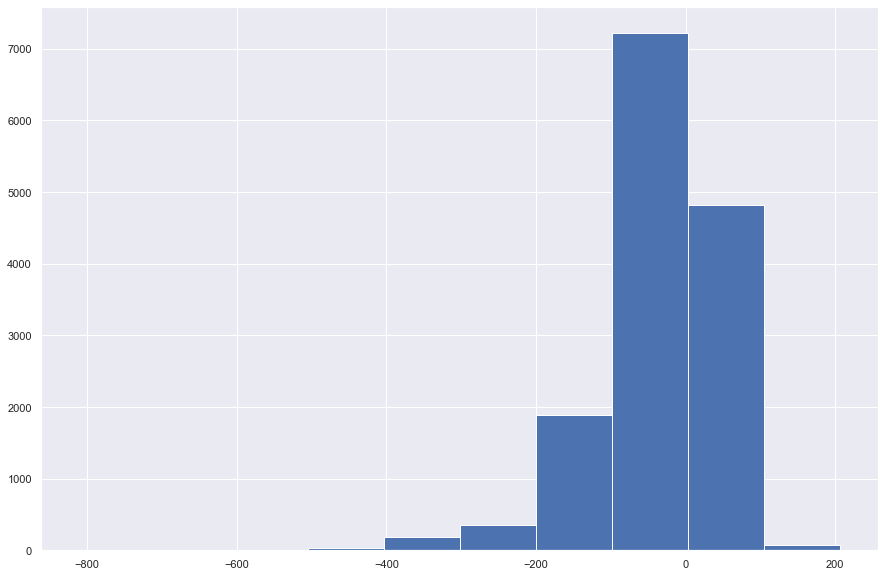

In [152]:
data['company_profile_read_score'].hist()

<AxesSubplot:>

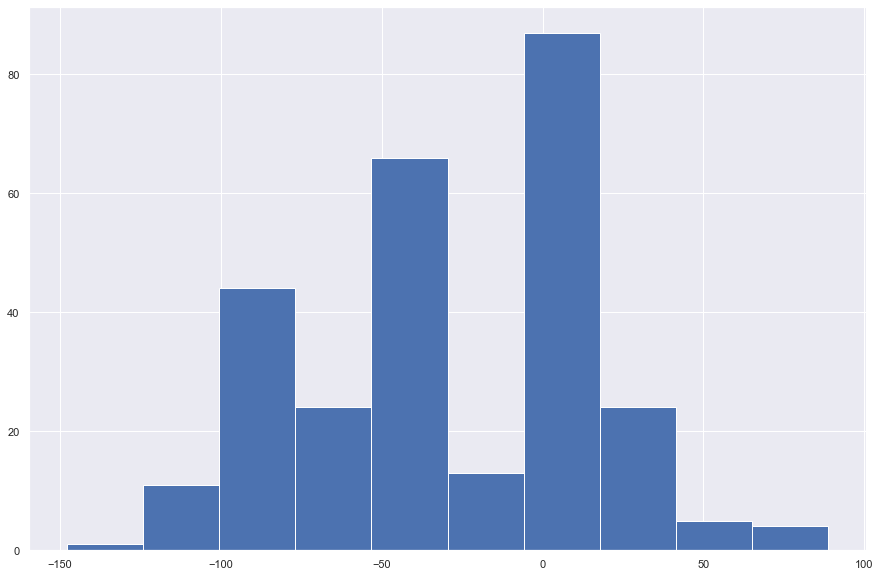

In [153]:
data['company_profile_read_score'][data['fraudulent'] == 't'].hist()

<AxesSubplot:>

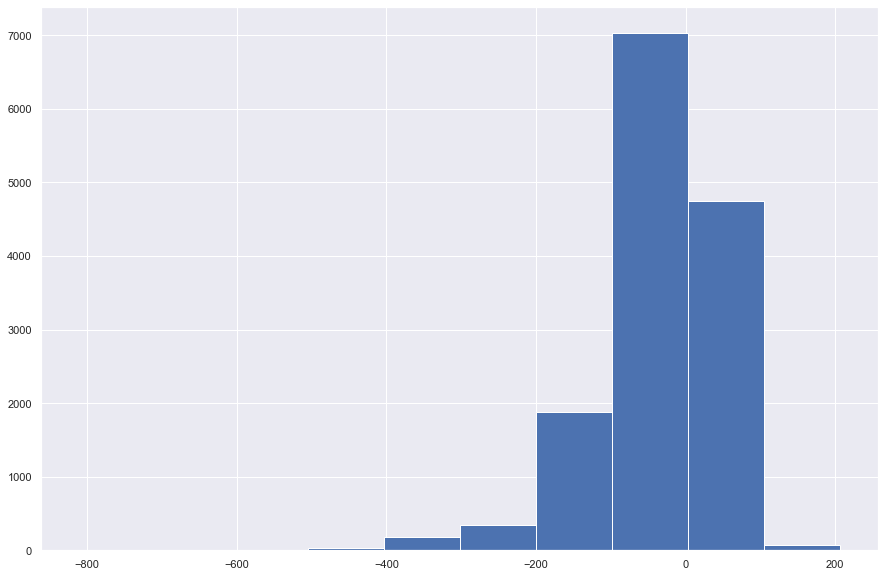

In [154]:
data['company_profile_read_score'][data['fraudulent'] == 'f'].hist()

<AxesSubplot:>

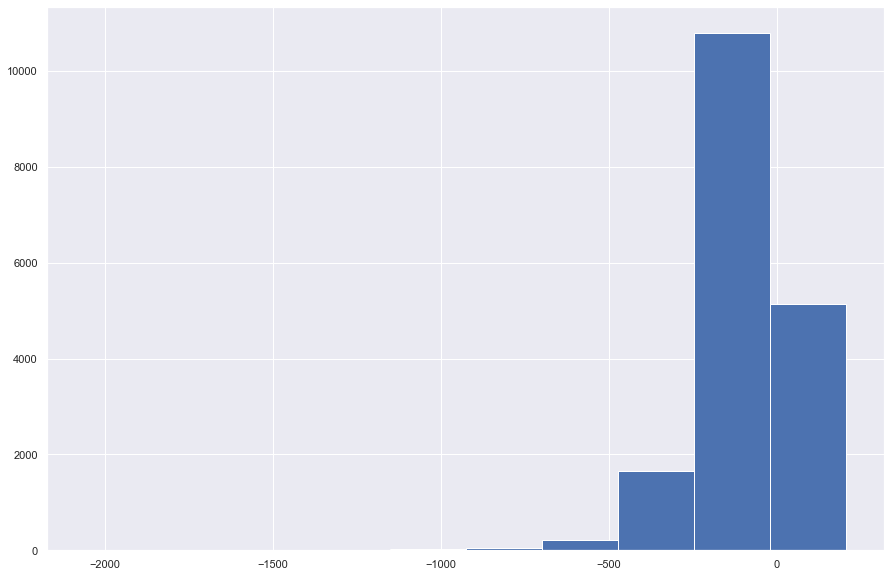

In [155]:
data['description_read_score'].hist()

<AxesSubplot:>

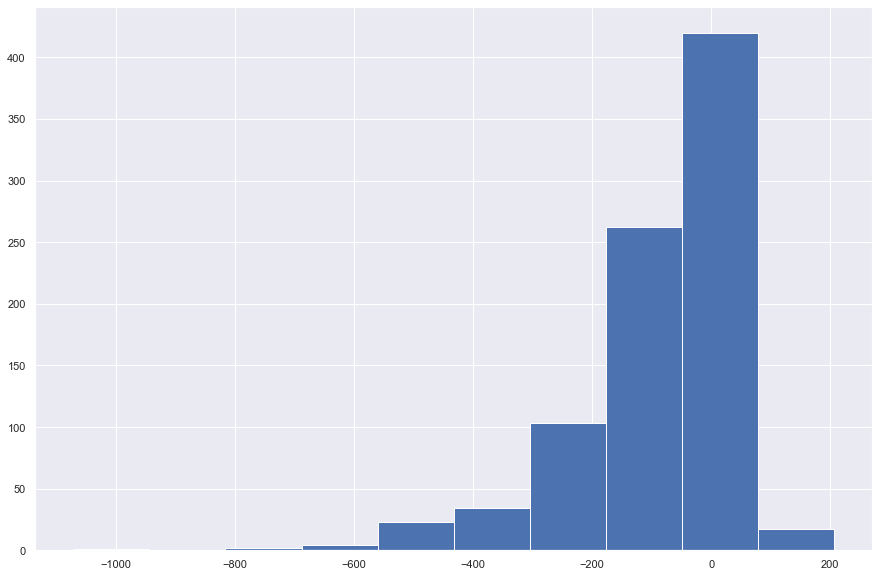

In [156]:
data['description_read_score'][data['fraudulent'] == 't'].hist()

<AxesSubplot:>

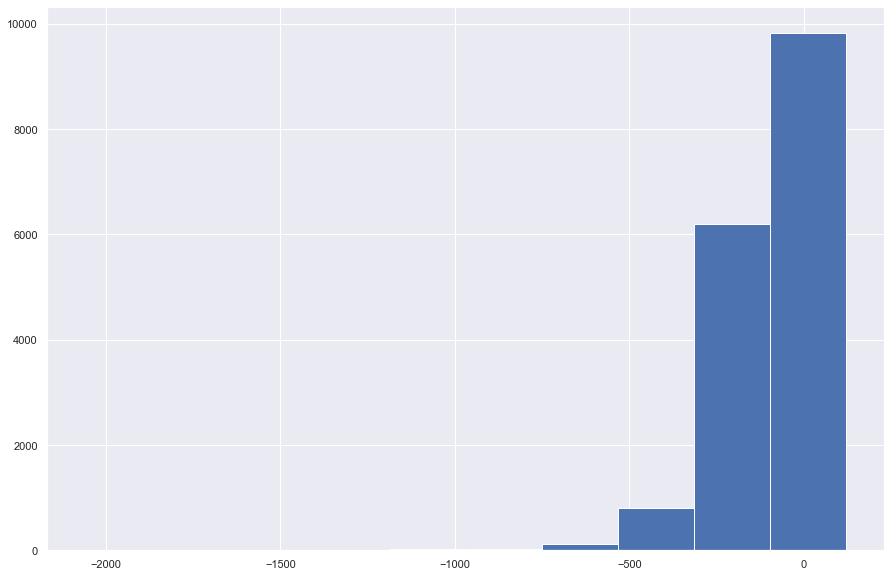

In [157]:
data['description_read_score'][data['fraudulent'] == 'f'].hist()

<AxesSubplot:>

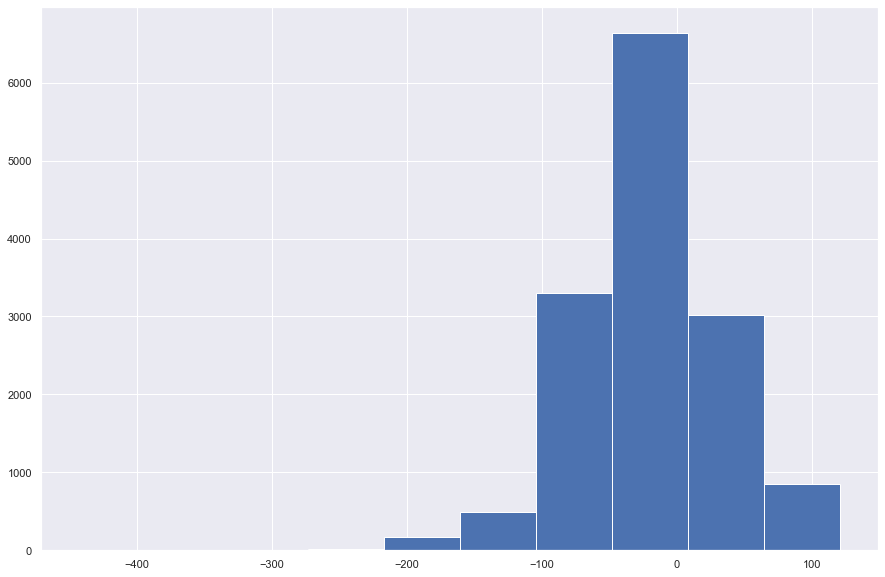

In [110]:
data['company_profile_cleaned_read_score'].hist()

<AxesSubplot:>

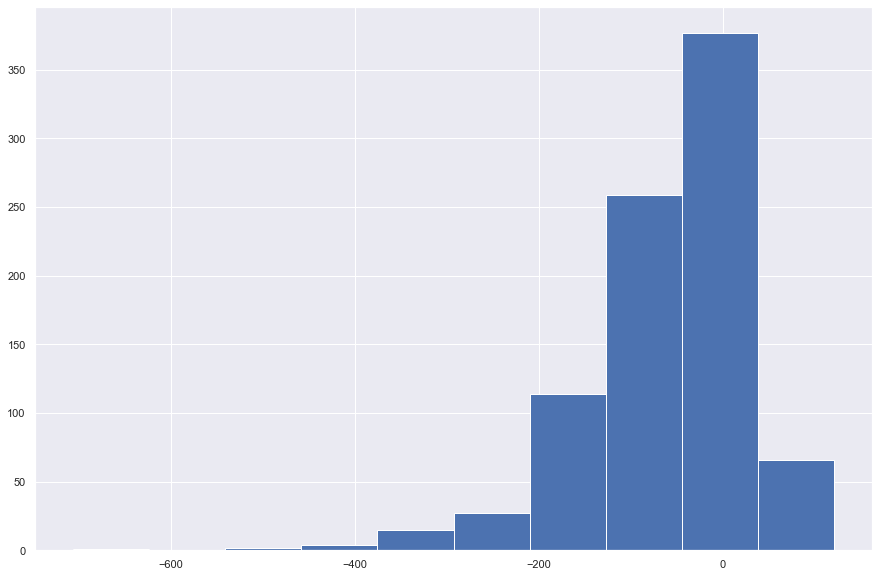

In [127]:
data['description_cleaned_read_score'][data['fraudulent'] == 't'].hist()

In [130]:
data['description'][data['description_cleaned_read_score'] < -100].iloc[0]

"<p>Organised - Focused - Vibrant - Awesome!<br><br>Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0</p>\r\n<p>We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.<br><br>Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!<br><br></p>\r\n<p>We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa0</p>\r\n<p><b>90 Se

<AxesSubplot:>

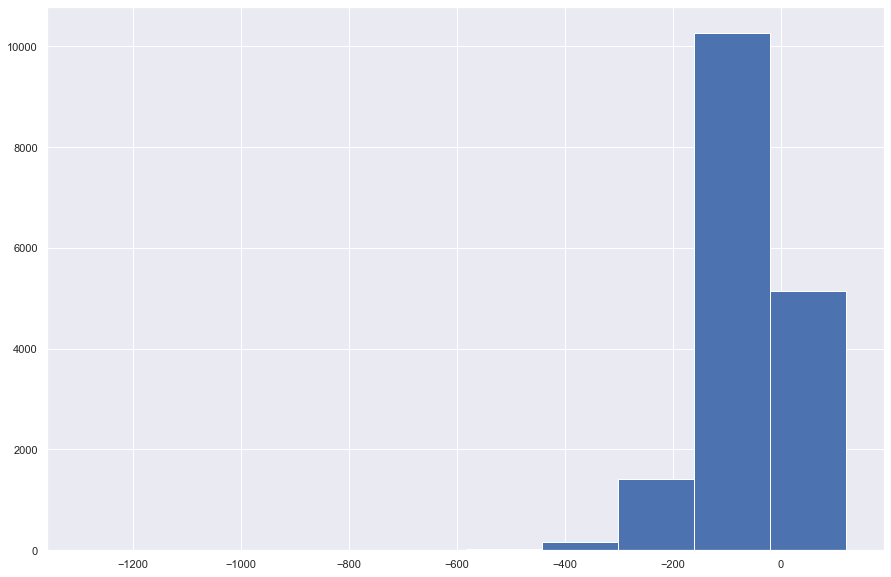

In [125]:
data['description_cleaned_read_score'][data['fraudulent'] == 'f'].hist()

# Feature Engineering #11

### Creating a feature to determine average number of words per sentence for each text field

In [120]:
clean_up_cols = ['company_profile_cleaned', 'requirements_cleaned', 'description_cleaned', 'benefits_cleaned']

for col in clean_up_cols:
    # name cleaned up column
    col_name = col + '_words_per_sentence'

    # initiate empty column
    data[col_name] = 0.0

    for i in range(len(data[col])):
        
        # if data is na, place NAN object
        if pd.isna(data[col][i]):
            data[col_name][i] = np.NAN
        else:
            # assign read score to field
            data[col_name][i] = textstat.words_per_sentence(data[col][i])

<AxesSubplot:>

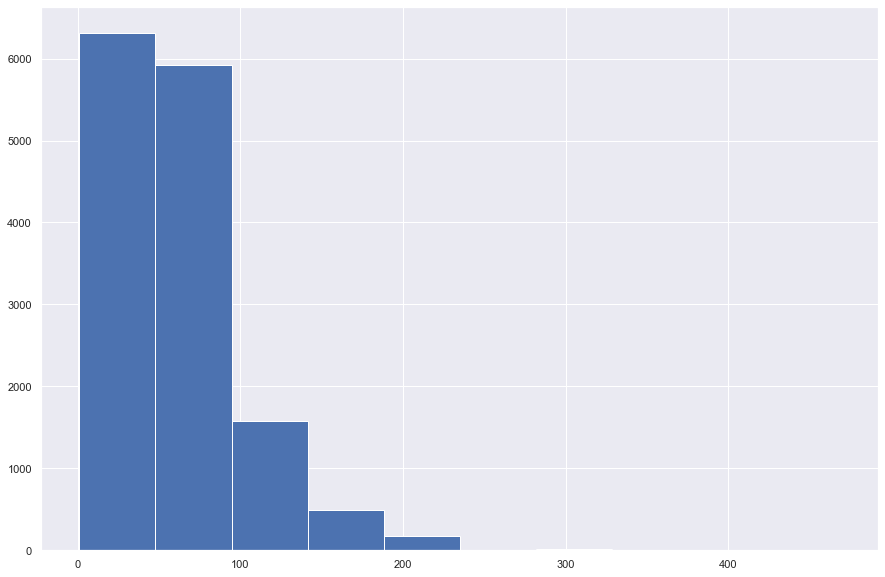

In [122]:
data['company_profile_cleaned_words_per_sentence'].hist()

<AxesSubplot:>

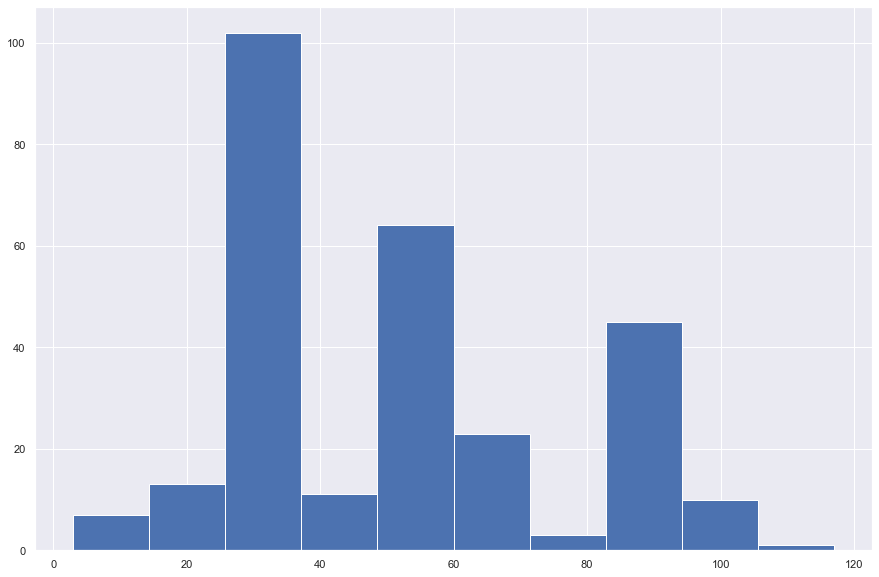

In [121]:
data['company_profile_cleaned_words_per_sentence'][data['fraudulent'] == 't'].hist()

<AxesSubplot:>

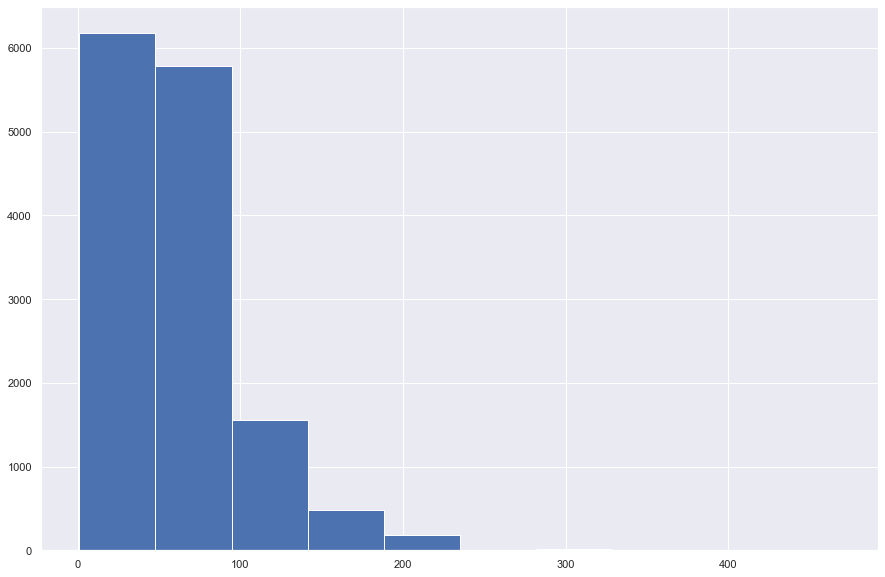

In [123]:
data['company_profile_cleaned_words_per_sentence'][data['fraudulent'] == 'f'].hist()

# Feature Engineering #12

### Computing sentiment score for each text field

In [139]:
clean_up_cols = ['company_profile_cleaned', 'requirements_cleaned', 'description_cleaned', 'benefits_cleaned']

for col in clean_up_cols:
    # name cleaned up column
    col_name = col + '_sentiment'

    # initiate empty column
    data[col_name] = 0.0

    for i in range(len(data[col])):
        
        # if data is na, place NAN object
        if pd.isna(data[col][i]):
            data[col_name][i] = np.NAN
        else:
            # assign read score to field
            data[col_name][i] = TextBlob(data[col][i]).sentiment.polarity

# Feature Engineering #13

### Checking for external references in text fields

In [ ]:
external_refs = ['apply at', 'call me', 'call us', 'contact us', 'send us', 'send resume']

clean_up_cols = ['company_profile', 'requirements', 'description', 'benefits']

for col in clean_up_cols:
    
    # name cleaned up column
    cleaned_col_name = col + '_external_ref'

    # initiate empty column
    data[cleaned_col_name] = False


    for i in range(len(data[col])):

        # if data is na, place empty string
        if pd.isna(data[col][i]):
            data[cleaned_col_name][i] = np.NAN
        else:

            # dont need entire nlp pipeline so parser and ner are disabled        
            text_doc = nlp(data[col][i], disable=['parser', 'ner'])

            # text is converted to lowercase, and separated by whitespace
            text = [tok.text.lower().strip() for tok in text_doc]

            # stopwords and punctuation marks are filtered out
            text = [tok for tok in text if tok in words and tok not in stop_words and tok not in punctuations and tok.isnumeric() is False]
            # the resulting token list is joined back into a sentence
            text =  ' '.join(text)

            for word in external_refs:
                if word in text:
                    data[cleaned_col_name][i] = True



In [18]:
data.to_csv('mod_data.csv', index = False)

<li> Create Term Document Matrix, and compute TF-IDF
<li> Create city plot - plot post locations
<li> Create bigrams and trigrams
<li> Create feature seeing whether external applications are asked for: call us, mailto, send resume, etc